In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Cause plots to be displayed in the notebook:
%pylab inline
%matplotlib inline

# Override default figure sizing:
#pylab.rcParams['figure.figsize'] = (10, 6)
sns.set(color_codes = True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
missing_values=["n/a","na","--","?"]
df=pd.read_csv('../../dataproject/train.csv', na_values=missing_values)
#dftest=pd.read_csv('../../dataproject/test.csv', na_values=missing_values)

In [3]:
df['date']=pd.to_datetime(df['date'])

## Time serie for store 1 item 1

In [4]:
df_store1 =df[(df['store']==1)&(df['item']==1)]
#df_store1

In [5]:
timeseries_columns = ['date','sales']
ts_store1=df_store1[timeseries_columns]
ts_store1=ts_store1.set_index('date')
#ts_store1

In [6]:
#sum(ts_store1.isnull().sum())

In [37]:
#ts_store1.plot()

Text(0, 0.5, 'sales')

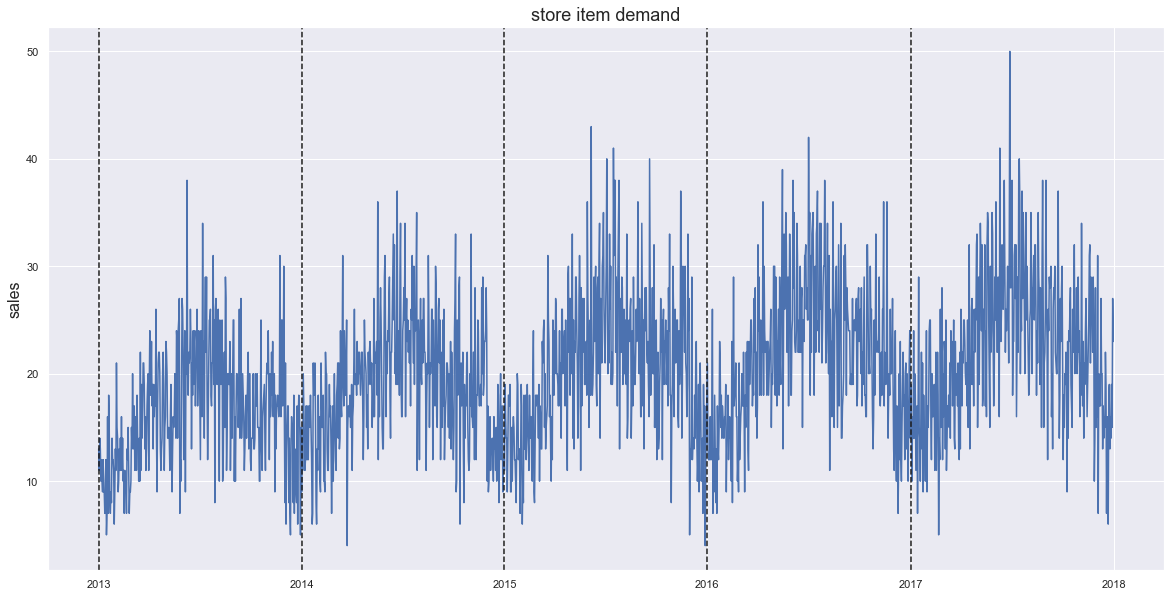

In [8]:
plt.figure(figsize = (20,10))
plt.plot(ts_store1)
for year in range(2013,2018):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--')
plt.title('store item demand', fontsize = 18)
plt.ylabel('sales', fontsize = 16)

### Split Train/Test

In [25]:
train = ts_store1.iloc[:len(ts_store1)-92] 
test = ts_store1.iloc[len(ts_store1)-92:] # set 3 months(92 days)) for testing

## Dickey-Fuller Test

In [77]:
from statsmodels.tsa.stattools import adfuller

In [78]:
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.936551
p-value: 0.041260
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


as the p-value is less than 0.05 (0.04), the null hypotesis is rejected and the data could be classified as stationary. so d=0

In [79]:
# Differential of a period of 1
diff = train.diff().dropna()
# Differential of a period of 365 (Yearly Seasonality)
diff_365 = train.diff(periods = 365).dropna()
# Differential of a period of 7 (Weekly Seasonality)
diff_7 = train.diff(periods = 7).dropna()

In [14]:
result = adfuller(diff_365)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.239552
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [15]:
result = adfuller(diff_7)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.686251
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


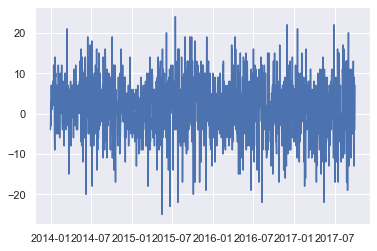

In [16]:
plt.plot(diff_365)

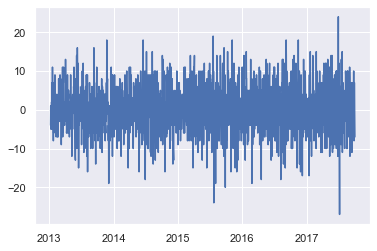

In [17]:
plt.plot(diff_7)

## SARIMA Model

it adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality

Trend Elements
There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:
p: Trend autoregression order.
d: Trend difference order.
q: Trend moving average order.
Seasonal Elements
There are four seasonal elements that are not part of ARIMA that must be configured; they are:
P: Seasonal autoregressive order.
D: Seasonal difference order.
Q: Seasonal moving average order.
m: The number of time steps for a single seasonal period.

the m parameter influences the P, D, and Q parameters. For example, an m of 12 for monthly data suggests a yearly seasonal cycle.

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

Model using weekly seasonality m=7

In [103]:
model_trial = SARIMAX(train, order = (4,1,1), seasonal_order = (1,0,1,7), 
                     enforce_stationary = False, 
                     enforce_invertibility = False).fit()

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [104]:
start = len(train) 
end = len(train) + len(test) - 1
predict1 = model_trial.predict(start, end)

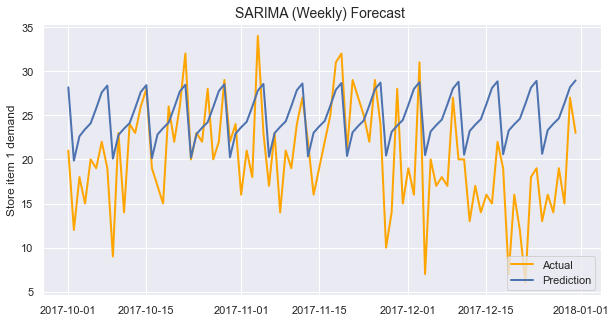

In [105]:
plt.figure(figsize=(10,5))
# plt.fill_between(test.index, predict[-1][:,1], predict[-1][:,0], 
#                  alpha = 0.25, color = 'black')
plt.plot(test, linewidth = 2, label = 'Actual', color = 'orange')
plt.plot(predict1, linewidth = 2, label = 'Prediction',  color = 'b')
plt.title('SARIMA (Weekly) Forecast ', fontsize = 14)
plt.legend(loc = 'lower right')
plt.ylabel('Store item 1 demand')
plt.show()

### Model using yearly cycle m=365 (m of 365 for daily data suggest a yearly seasonal cycle) (1,0,0) (0,1,0,365)

In [ ]:
#model_best = SARIMAX(train, order = (1,0,0), seasonal_order = (0,1,0,365), 
                      enforce_stationary = False, 
                      enforce_invertibility = False, freq = 'D').fit()

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [38]:
# To save results into a csv file
#start = len(train) 
#end = len(train) + len(test) - 1
#predict_365 = model_best.predict(start, end)
#predict_365.to_csv('SARIMA_365_prediction_q0.csv')

In [114]:
# To avoid running the 365 interval again, the results was collected into a csv file

predict_365 = pd.read_csv('SARIMA_365_prediction_q0.csv')
predict_365.columns = ['date', 'predict']
predict_365['date'] = pd.to_datetime(predict_365['date'])
predict_365.set_index('date', inplace = True)
predict_365.head()

,predict
date,
2017-10-01,24.846157
2017-10-02,26.003381
2017-10-03,19.999926
2017-10-04,28.000002
2017-10-05,17.000000


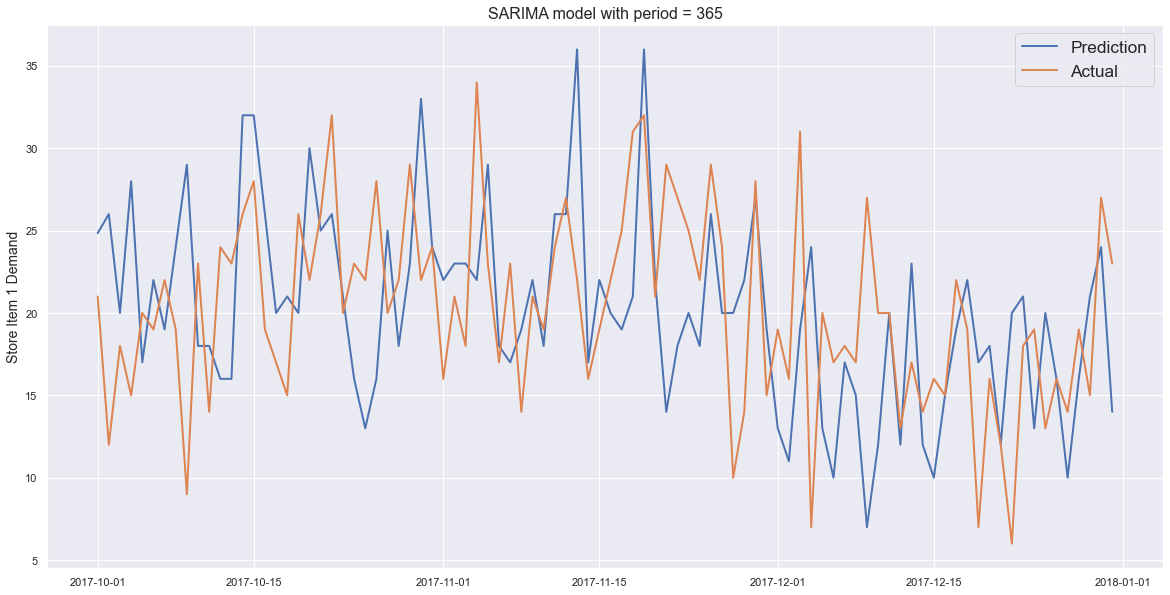

In [115]:
plt.figure(figsize = (20,10))
plt.plot(predict_365, linewidth = 2)
plt.plot(test, linewidth = 2)
plt.title('SARIMA model with period = 365', fontsize = 16)
plt.ylabel('Store Item 1 Demand', fontsize = 14)
plt.legend(['Prediction', 'Actual'], fontsize = 'x-large')
#plt.savefig('SARIMA_365.png')
plt.show()

### SARIMAX with Fourier Terms

Utilize exogenous variables in SARIMAX to model additional seasonalities with Fourier terms. yearly season equals 365.25 to account for leap years.
The seasonal pattern is modeled through the addition of Fourier terms which are used as external regressors. This approach is flexible, allowing to incorporate multiple periods. Each seasonality is modeled by a trigonometric representation based on Fourier series

Weekly pattern with seasonal of sarima and yearly pattern with 2 furier terms as exogenous variable

In [15]:
#ts_store1_fourier=ts_store1.copy()

In [17]:
#ts_store1_fourier

In [10]:
# prepare Fourier terms for yearly seasonality pattern
ts_store1['sin365'] = np.sin(2 * np.pi * ts_store1.index.dayofyear / 365.25)
ts_store1['cos365'] = np.cos(2 * np.pi * ts_store1.index.dayofyear / 365.25)
ts_store1['sin365_2'] = np.sin(4 * np.pi * ts_store1.index.dayofyear / 365.25)
ts_store1['cos365_2'] = np.cos(4 * np.pi * ts_store1.index.dayofyear / 365.25)

In [11]:
ts_store1

,sales,sin365,cos365,sin365_2,cos365_2
date,,,,,
2013-01-01,13,0.017202,0.999852,0.034398,0.999408
2013-01-02,11,0.034398,0.999408,0.068755,0.997634
2013-01-03,14,0.051584,0.998669,0.103031,0.994678
2013-01-04,13,0.068755,0.997634,0.137185,0.990545
2013-01-05,10,0.085906,0.996303,0.171177,0.985240
...,...,...,...,...,...
2017-12-27,14,-0.073045,0.997329,-0.145700,0.989329
2017-12-28,19,-0.055879,0.998438,-0.111583,0.993755
2017-12-29,15,-0.038696,0.999251,-0.077334,0.997005


In [12]:
train = ts_store1.iloc[:(len(ts_store1)-92)]['sales']
test= ts_store1.iloc[(len(ts_store1)-92):]['sales']
exog_train = ts_store1.drop(['sales'], axis = 1)[:len(ts_store1)-92]
exog_test = ts_store1.drop(['sales'], axis = 1)[len(ts_store1)-92:]

In [13]:
#train_fourier

In [80]:
#test

In [12]:
exog_test

,sin365,cos365,sin365_2,cos365_2
date,,,,
2017-10-01,-0.999999,0.001075,-0.002150,-0.999998
2017-10-02,-0.999833,0.018277,-0.036547,-0.999332
2017-10-03,-0.999371,0.035473,-0.070900,-0.997483
2017-10-04,-0.998613,0.052658,-0.105170,-0.994454
2017-10-05,-0.997559,0.069828,-0.139315,-0.990248
...,...,...,...,...
2017-12-27,-0.073045,0.997329,-0.145700,0.989329
2017-12-28,-0.055879,0.998438,-0.111583,0.993755
2017-12-29,-0.038696,0.999251,-0.077334,0.997005


order = (6,1,1), seasonal_order = (1,0,2,7)

In [71]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
model_exog1 = SARIMAX(train, order = (6,1,5), seasonal_order = (1,0,2,7), 
                exog = exog_train, 
                enforce_stationary = False, 
                enforce_invertibility = False, 
                freq = 'D').fit()

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [72]:
predict_exog1 = model_exog1.forecast(steps=92,exog=exog_test)

In [136]:
predict_exog1

2017-10-01    27.320691
2017-10-02    18.552676
2017-10-03    20.737704
2017-10-04    22.617566
2017-10-05    23.174550
                ...    
2017-12-27    17.183716
2017-12-28    18.139844
2017-12-29    19.654772
2017-12-30    21.721504
2017-12-31    21.495149
Freq: D, Length: 92, dtype: float64

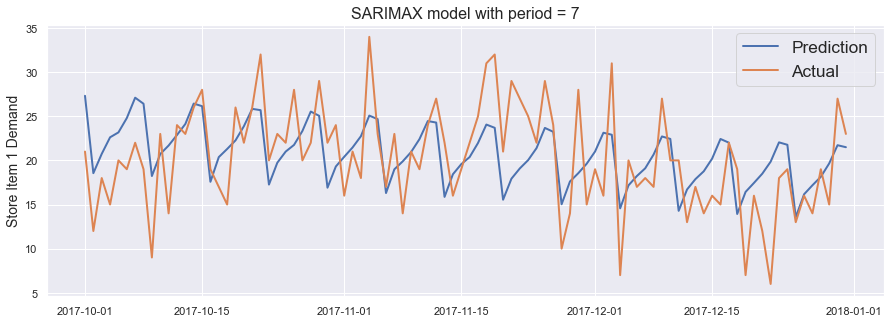

In [73]:
plt.figure(figsize = (15,5))
plt.plot(predict_exog1, linewidth = 2)
plt.plot(test, linewidth = 2)
plt.title('SARIMAX model with period = 7', fontsize = 16)
plt.ylabel('Store Item 1 Demand', fontsize = 14)
plt.legend(['Prediction', 'Actual'], fontsize = 'x-large')
#plt.savefig('SARIMA_365.png')
plt.show()

In [74]:
print('SARIMAX: Includes Both Weekly and Yearly Seasonality (6,1,1), seasonal_order = (1,0,2,7)')
regPrintErr(test, predict_exog1)

SARIMAX: Includes Both Weekly and Yearly Seasonality (6,1,1), seasonal_order = (1,0,2,7)
R2 Score: 0.27032443105256676
MAPE: 23.18445582387081
RMSE: 4.974651472370672


###

In [67]:
model_exog2 = SARIMAX(train, order = (4,1,1), seasonal_order = (1,0,2,7), 
                exog = exog_train, 
                enforce_stationary = False, 
                enforce_invertibility = False, 
                freq = 'D').fit()

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [68]:
predict_exog2 = model_exog2.forecast(steps=92,exog=exog_test)

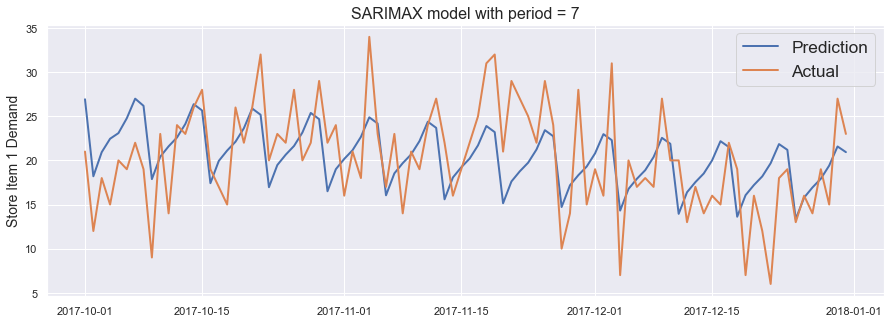

In [69]:
plt.figure(figsize = (15,5))
plt.plot(predict_exog2, linewidth = 2)
plt.plot(test, linewidth = 2)
plt.title('SARIMAX model with period = 7', fontsize = 16)
plt.ylabel('Store Item 1 Demand', fontsize = 14)
plt.legend(['Prediction', 'Actual'], fontsize = 'x-large')
#plt.savefig('SARIMA_365.png')
plt.show()

In [70]:
print('SARIMAX: Includes Both Weekly and Yearly Seasonality (4,1,1), seasonal_order = (1,0,2,7)')
regPrintErr(test, predict_exog2)

SARIMAX: Includes Both Weekly and Yearly Seasonality (4,1,1), seasonal_order = (1,0,2,7)
R2 Score: 0.2662052014750729
MAPE: 22.904606544876692
RMSE: 4.9886733837936275


order = (4,1,1), seasonal_order = (1,0,2,7)

In [82]:
###from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
model_exog3 = SARIMAX(train, order = (4,1,1), seasonal_order = (1,0,1,7), 
                exog = exog_train, 
                enforce_stationary = False, 
                enforce_invertibility = False, 
                freq = 'D').fit()

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [83]:
predict_exog3 = model_exog3.forecast(steps=92,exog=exog_test)

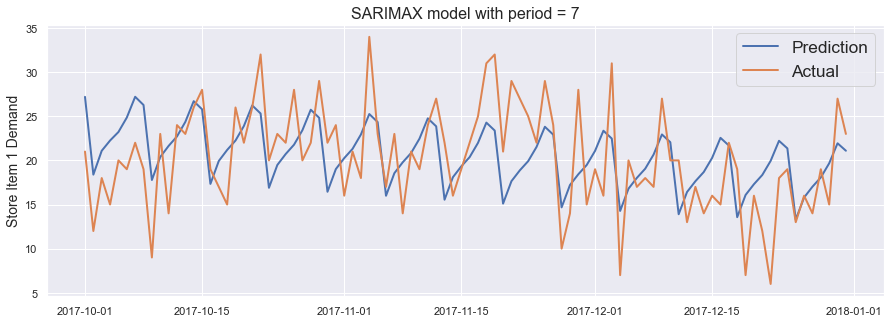

In [84]:
plt.figure(figsize = (15,5))
plt.plot(predict_exog3, linewidth = 2)
plt.plot(test, linewidth = 2)
plt.title('SARIMAX model with period = 7', fontsize = 16)
plt.ylabel('Store Item 1 Demand', fontsize = 14)
plt.legend(['Prediction', 'Actual'], fontsize = 'x-large')
#plt.savefig('SARIMA_365.png')
plt.show()

In [85]:
print('SARIMAX: Includes Both Weekly and Yearly Seasonality (4,1,1), seasonal_order = (1,0,2,7)')
regPrintErr(test, predict_exog3)

SARIMAX: Includes Both Weekly and Yearly Seasonality (4,1,1), seasonal_order = (1,0,2,7)
R2 Score: 0.26167587053574637
MAPE: 23.179570801476817
RMSE: 5.004045932512283


### Walk-Forward Validation

(1,0,0), seasonal_order = (0,1,1,7)

In [16]:
# walk-forward validation
history = [x for x in train]
exog_hist = exog_train.copy()
predictions1 = list()

for i in range(len(test)):
    # predict
    model1 = SARIMAX(history, order = (1,0,0), seasonal_order = (0,1,1,7), 
                exog = exog_hist, 
                enforce_stationary = False, 
                enforce_invertibility = False, 
                freq = 'D')
    model_fit = model1.fit()
    yhat = model_fit.forecast(exog = exog_test.iloc[i,:]) #Forecasting the next step
    predictions1.append(yhat)
    # observation
    obs = test[i]    #Actual data on this day
    history.append(obs)
    exog_hist = exog_hist.append(exog_test.iloc[i,:])

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

In [17]:
predictions_complete1 = pd.Series()
for i in predictions1:
    predictions_complete1 = predictions_complete1.append(i)

<ipython-input-17-95ea19e01784>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_complete1 = pd.Series()


In [18]:
a = pd.DataFrame(test)
b = pd.DataFrame(predictions_complete1)
b.set_index(test.index, inplace = True)
compare1 = pd.concat([a,b],axis = 1)
compare1.columns = ['Actual', 'Predict']
compare1.head()

,Actual,Predict
date,,
2017-10-01,21,26.982131
2017-10-02,12,16.816182
2017-10-03,18,19.809389
2017-10-04,15,21.634418
2017-10-05,20,22.450313


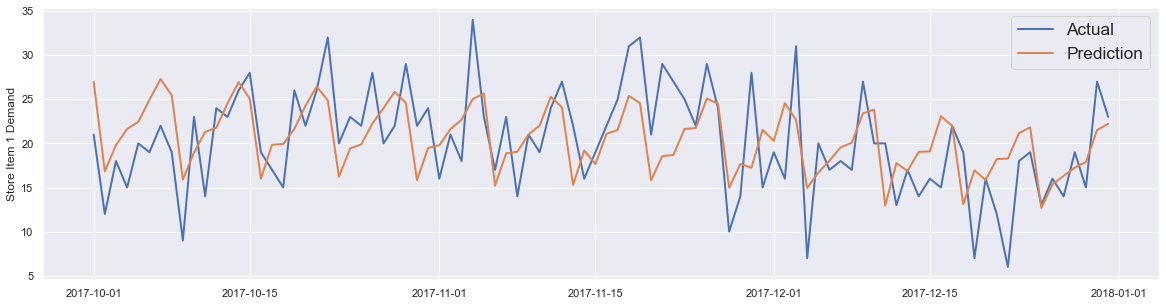

In [19]:
plt.figure(figsize = (20,5))
plt.plot(compare1['Actual'], label = 'Actual', linewidth = 2)
plt.plot(compare1['Predict'], label = 'Prediction', linewidth = 2)
plt.legend(fontsize = 'x-large')
plt.ylabel('Store Item 1 Demand')
plt.show()

In [ ]:
print('SARIMAX: Includes Both Weekly and Yearly Seasonality (4,1,1), seasonal_order = (1,0,2,7)')
regPrintErr(test, compare1['Actual'])

In [86]:
# walk-forward validation
history = [x for x in train]
exog_hist = exog_train.copy()
predictions2 = list()

for i in range(len(test)):
    # predict
    model2 = SARIMAX(history, order = (4,1,1), seasonal_order = (1,0,2,7), 
                exog = exog_hist, 
                enforce_stationary = False, 
                enforce_invertibility = False, 
                freq = 'D')
    model_fit = model2.fit()
    yhat = model_fit.forecast(exog = exog_test.iloc[i,:]) #Forecasting the next step
    predictions2.append(yhat)
    # observation
    obs = test[i]    #Actual data on this day
    history.append(obs)
    exog_hist = exog_hist.append(exog_test.iloc[i,:])

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likeli

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likeli

In [87]:
predictions_complete2 = pd.Series()
for i in predictions2:
    predictions_complete2 = predictions_complete2.append(i)

<ipython-input-87-2cea6f3a682f>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_complete2 = pd.Series()


In [88]:
predictions_complete2.to_csv('SARIMAX_WALKFORWARD_411.csv')
#predictions_complete2 = pd.read_csv('SARIMAX_WALKFORWARD_411.csv')
#predict_365.columns = ['date', 'predict']
#predict_365['date'] = pd.to_datetime(predict_365['date'])
#predict_365.set_index('date', inplace = True)
#predict_365.head()

In [91]:
c = pd.DataFrame(test)
d = pd.DataFrame(predictions_complete2)
d.set_index(test.index, inplace = True)
compare2 = pd.concat([c,d],axis = 1)
compare2.columns = ['Actual2', 'Predict2']
compare2.head()

,Actual2,Predict2
date,,
2017-10-01,21,26.925491
2017-10-02,12,17.809493
2017-10-03,18,20.462348
2017-10-04,15,22.086040
2017-10-05,20,21.950877


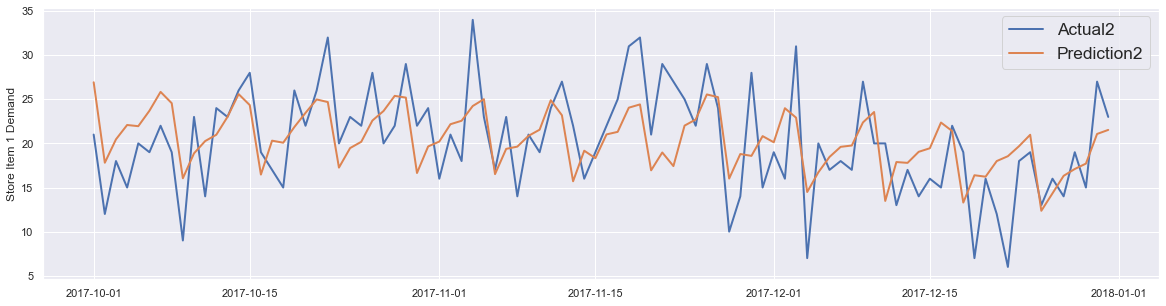

In [92]:
plt.figure(figsize = (20,5))
plt.plot(compare2['Actual2'], label = 'Actual2', linewidth = 2)
plt.plot(compare2['Predict2'], label = 'Prediction2', linewidth = 2)
plt.legend(fontsize = 'x-large')
plt.ylabel('Store Item 1 Demand')
plt.show()

In [95]:
print('SARIMAX: Includes Both Weekly and Yearly Seasonality (4,1,1), seasonal_order = (1,0,2,7)')
regPrintErr(compare2['Actual2'],compare2['Predict2'])

SARIMAX: Includes Both Weekly and Yearly Seasonality (4,1,1), seasonal_order = (1,0,2,7)
R2 Score: 0.31016869513887524
MAPE: 22.544750794466403
RMSE: 4.836923357753059


(4,1,1), seasonal_order = (1,0,1,7) results from auto_arima

In [119]:
# walk-forward validation
history = [x for x in train]
exog_hist = exog_train.copy()
predictions3 = list()

for i in range(len(test)):
    # predict
    model3 = SARIMAX(history, order = (4,1,1), seasonal_order = (1,0,1,7), 
                exog = exog_hist, 
                enforce_stationary = False, 
                enforce_invertibility = False, 
                freq = 'D')
    model_fit = model3.fit()
    yhat = model_fit.forecast(exog = exog_test.iloc[i,:]) #Forecasting the next step
    predictions3.append(yhat)
    # observation
    obs = test[i]    #Actual data on this day
    history.append(obs)
    exog_hist = exog_hist.append(exog_test.iloc[i,:])

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likeli

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likeli

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likeli

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likeli

In [120]:
predictions_complete3 = pd.Series()
for i in predictions3:
    predictions_complete3 = predictions_complete3.append(i)

<ipython-input-120-a4add5a5084f>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_complete3 = pd.Series()


In [121]:
predictions_complete3.to_csv('SARIMAX_WALKFORWARD_411_1017.csv')

In [122]:
e = pd.DataFrame(test)
f = pd.DataFrame(predictions_complete3)
f.set_index(test.index, inplace = True)
compare3 = pd.concat([e,f],axis = 1)
compare3.columns = ['Actual3', 'Predict3']
compare3.head()

,Actual3,Predict3
date,,
2017-10-01,21,27.200808
2017-10-02,12,17.970798
2017-10-03,18,20.664465
2017-10-04,15,21.610142
2017-10-05,20,21.751867


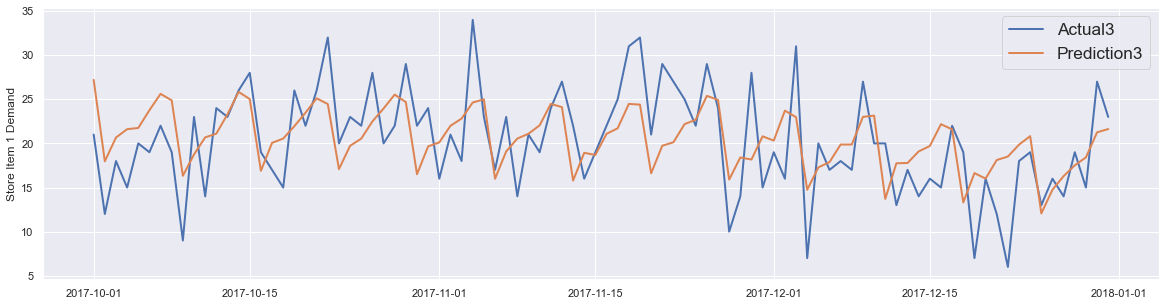

In [123]:
plt.figure(figsize = (20,5))
plt.plot(compare3['Actual3'], label = 'Actual3', linewidth = 2)
plt.plot(compare3['Predict3'], label = 'Prediction3', linewidth = 2)
plt.legend(fontsize = 'x-large')
plt.ylabel('Store Item 1 Demand')
plt.show()

In [125]:
print('SARIMAX: Includes Both Weekly and Yearly Seasonality (4,1,1), seasonal_order = (1,0,2,7)')
regPrintErr(compare3['Actual3'],compare3['Predict3'])

SARIMAX: Includes Both Weekly and Yearly Seasonality (4,1,1), seasonal_order = (1,0,2,7)
R2 Score: 0.3280446641385626
MAPE: 22.39444878562704
RMSE: 4.773841108255746


In [30]:
# walk-forward validation
history = [x for x in train]
exog_hist = exog_train.copy()
predictions4 = list()

for i in range(len(test)):
    # predict
    model4 = SARIMAX(history, order = (6,1,0), seasonal_order = (0,1,1,7), 
                exog = exog_hist, 
                enforce_stationary = False, 
                enforce_invertibility = False, 
                freq = 'D')
    model_fit = model4.fit()
    yhat = model_fit.forecast(exog = exog_test.iloc[i,:]) #Forecasting the next step
    predictions4.append(yhat)
    # observation
    obs = test[i]    #Actual data on this day
    history.append(obs)
    exog_hist = exog_hist.append(exog_test.iloc[i,:])

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood o

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood o

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency infor

C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\monic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

In [31]:
predictions_complete4 = pd.Series()
for i in predictions4:
    predictions_complete4 = predictions_complete4.append(i)

<ipython-input-31-4a5ea1c71236>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_complete4 = pd.Series()


In [32]:
predictions_complete4.to_csv('SARIMAX_Walkforward_610.csv')

In [ ]:
# To avoid running again, the results was collected into a csv file
predictions_complete4 = pd.read_csv('SARIMAX_Walkforward_411.csv')
predict_365.columns = ['date', 'predict']
predict_365['date'] = pd.to_datetime(predict_365['date'])
predict_365.set_index('date', inplace = True)
predict_365.head()

In [33]:
e = pd.DataFrame(test)
f = pd.DataFrame(predictions_complete4)
f.set_index(test.index, inplace = True)
compare4 = pd.concat([e,f],axis = 1)
compare4.columns = ['Actual4', 'Predict4']
compare4.head()

,Actual4,Predict4
date,,
2017-10-01,21,26.999433
2017-10-02,12,18.049901
2017-10-03,18,20.440642
2017-10-04,15,21.745602
2017-10-05,20,20.125147


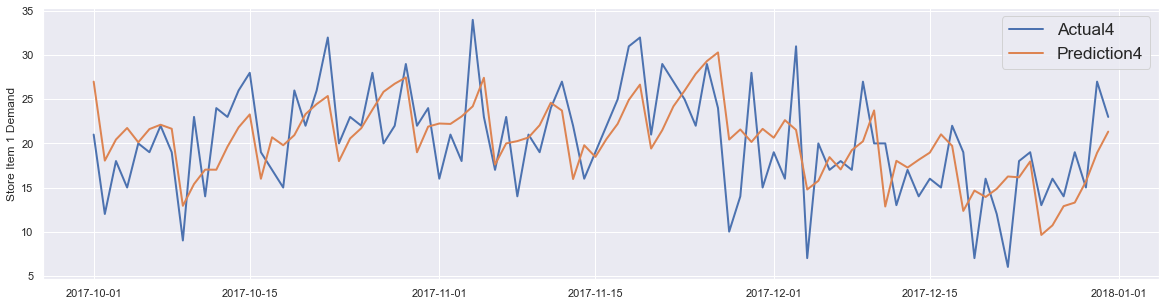

In [34]:
plt.figure(figsize = (20,5))
plt.plot(compare4['Actual4'], label = 'Actual4', linewidth = 2)
plt.plot(compare4['Predict4'], label = 'Prediction4', linewidth = 2)
plt.legend(fontsize = 'x-large')
plt.ylabel('Store Item 1 Demand')
plt.show()

In [97]:
test.values

array([21, 12, 18, 15, 20, 19, 22, 19,  9, 23, 14, 24, 23, 26, 28, 19, 17,
       15, 26, 22, 26, 32, 20, 23, 22, 28, 20, 22, 29, 22, 24, 16, 21, 18,
       34, 23, 17, 23, 14, 21, 19, 24, 27, 22, 16, 19, 22, 25, 31, 32, 21,
       29, 27, 25, 22, 29, 24, 10, 14, 28, 15, 19, 16, 31,  7, 20, 17, 18,
       17, 27, 20, 20, 13, 17, 14, 16, 15, 22, 19,  7, 16, 12,  6, 18, 19,
       13, 16, 14, 19, 15, 27, 23], dtype=int64)

#### walk forward validation m=365

## Model Evaluation

## Evaluate the model using MSE and RMSE

In [25]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
# Evaluation metrics
# MAPE mean_absolute_percentage_error
def regMAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1.))) * 100


# print_error
def regPrintErr(y_true, y_pred):
    print('R2 Score: {}'.format(r2_score(y_true, y_pred)))
    print('MAPE: {}'.format(regMAPE(y_true, y_pred)))
    print('RMSE: {}'.format(sqrt(mean_squared_error(y_true, y_pred))))

In [102]:
#order = (1,0,0), seasonal_order = (0,1,1,7)
print('SARIMA: Weekly Seasonality')
regPrintErr(test, predict1)

SARIMA: Weekly Seasonality
R2 Score: -0.5702275537435224
MAPE: 36.48551255946151
RMSE: 7.297583171849058


In [106]:
print('SARIMA: Weekly Seasonality')
regPrintErr(test, predict1)

SARIMA: Weekly Seasonality
R2 Score: -0.4292802725175622
MAPE: 35.67291767988715
RMSE: 6.962359691586313


In [116]:
print('SARIMA: yearly Seasonality')
regPrintErr(test, predict_365['predict'])

SARIMA: yearly Seasonality
R2 Score: -0.498903138694649
MAPE: 31.51101769552177
RMSE: 7.1299180957627994


In [117]:
# Seasonality (4,1,1), seasonal_order = (1,0,2,7)
print('SARIMAX: Includes Both Weekly and Yearly')
regPrintErr(test, predict_exog2)

SARIMAX: Includes Both Weekly and Yearly Seasonality (4,1,1), seasonal_order = (1,0,2,7)
R2 Score: 0.2662052014750729
MAPE: 22.904606544876692
RMSE: 4.9886733837936275


In [126]:
###BEST
# (4,1,1), seasonal_order = (1,0,1,7)
print('SARIMAX - Walk-Forward')
regPrintErr(compare3['Actual3'], compare3['Predict3'])

SARIMAX - Walk-Forward
R2 Score: 0.3280446641385626
MAPE: 22.39444878562704
RMSE: 4.773841108255746


In [135]:
results = {'Actual': test.values, 'SARIMA (weekly)':predict1, 
         'SARIMA (Yearly)': predict_365['predict'], 'SARIMAX_wy_Fourier': predict_exog2, 'SARIMAX (Walk-Forward)': compare3['Predict3']}

In [137]:
#test

In [138]:
#predict1

In [131]:
results

{'Actual': array([21, 12, 18, 15, 20, 19, 22, 19,  9, 23, 14, 24, 23, 26, 28, 19, 17,
        15, 26, 22, 26, 32, 20, 23, 22, 28, 20, 22, 29, 22, 24, 16, 21, 18,
        34, 23, 17, 23, 14, 21, 19, 24, 27, 22, 16, 19, 22, 25, 31, 32, 21,
        29, 27, 25, 22, 29, 24, 10, 14, 28, 15, 19, 16, 31,  7, 20, 17, 18,
        17, 27, 20, 20, 13, 17, 14, 16, 15, 22, 19,  7, 16, 12,  6, 18, 19,
        13, 16, 14, 19, 15, 27, 23], dtype=int64),
 'SARIMA (weekly)': 2017-10-01    28.163247
 2017-10-02    19.857715
 2017-10-03    22.623073
 2017-10-04    23.417735
 2017-10-05    24.080831
                 ...    
 2017-12-27    24.026573
 2017-12-28    24.651830
 2017-12-29    26.362679
 2017-12-30    28.183077
 2017-12-31    28.946897
 Freq: D, Length: 92, dtype: float64,
 'SARIMA (Yearly)': date
 2017-10-01    24.846157
 2017-10-02    26.003381
 2017-10-03    19.999926
 2017-10-04    28.000002
 2017-10-05    17.000000
                 ...    
 2017-12-27    10.000000
 2017-12-28    16.000000
 2

In [128]:
results_SARIMA = pd.DataFrame(results)

In [129]:
results_SARIMA.head()

,Actual,SARIMA (weekly),SARIMA (Yearly),SARIMAX_wy_Fourier,SARIMAX (Walk-Forward)
2017-10-01,21,28.163247,24.846157,26.925491,27.200808
2017-10-02,12,19.857715,26.003381,18.200592,17.970798
2017-10-03,18,22.623073,19.999926,20.933126,20.664465
2017-10-04,15,23.417735,28.000002,22.454429,21.610142
2017-10-05,20,24.080831,17.000000,23.091248,21.751867


In [130]:
results_SARIMA.to_csv('results_SARIMA.csv')